In [2]:
import numpy as np
import time
from gridData import Grid
from skimage.measure import marching_cubes
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append('../')
from src.geometry_utils import intersection_triangle_square, distance_point_triangle
from scipy import ndimage

(40, 40, 40)


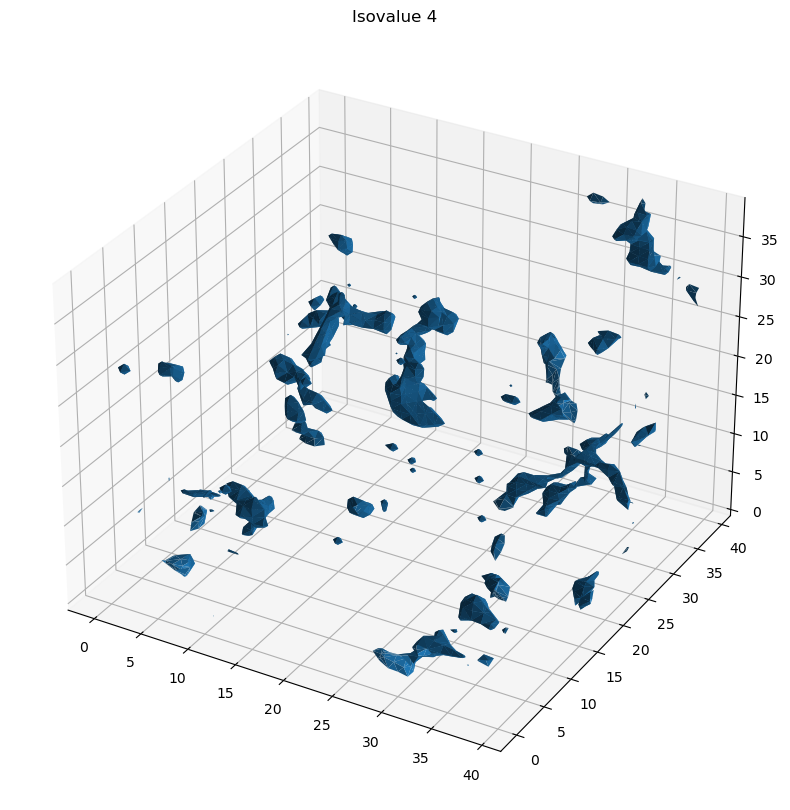

In [4]:
# example of isosurface creation 

iso = 4
g = Grid("path/to/dx/file")
grid = g.grid[20:60,20:60,20:60]
print(grid.shape)
verts, faces, _, _ = marching_cubes(grid, iso) #create isosurfaces with maching cubes algo
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                lw=1)
plt.title(f"Isovalue {iso}")
plt.show()

In [24]:
# this function creates a 2d array storing the 3d coordinates of the points of a plane.
# the plane is defined from three points P1 P2 P3
# `ppside` defines how many points there are along each side
# `spacing` defines the distance between two neighbouring points

def define_plane(P1, P2, P3, ppside, spacing):
    N = np.cross(P2-P1, P3-P1) #normal
    C = (P1+P2)/2 #center
    
    # first vector (could be anything)
    v1 = np.array([1.,1.,1.])
    v1 -= v1.dot(N) * N / np.linalg.norm(N)**2
    v1 /= np.linalg.norm(v1)
    
    # second vector
    v2 = np.cross(N, v1)
    v2 = v2 / np.linalg.norm(v2)
    
    # bottom left corner
    BL = C - (v1+v2)*ppside*spacing/2
    
    points = []
    
    for i in range(ppside):
        row = []
        for j in range(ppside):
            row.append(BL + v1*i*spacing + v2*j*spacing)
        points.append(np.array(row))
            
    return np.array(points)

In [25]:
# This function calculatres the iso surfaces for each iso value 
# but discards triangles that will not intrsect the plane define by `plane_vertices`
# (very slow)

def find_iso_surfaces(plane_vertices, center, grid, iso_values):
    
    iso_surfaces = []
    
    for iso in iso_values:
        print(f"Processing iso {iso}")

        #find triangles
        start = time.time()
        vertices, faces, _, _ = marching_cubes_lewiner(grid.grid, iso)
        vertices = np.array([p/2 + grid.origin for p in vertices])
        # transform whatever `faces` is to a set of three points defining a triangle
        triangles = []
        for i, f in enumerate(faces):
            P1 = vertices[f[0]]
            P2 = vertices[f[1]]
            P3 = vertices[f[2]]
            triangles.append([P1,P2,P3])
        triangles = np.array(triangles)
        print(f"Triangulation done in {time.time()-start} seconds")
        
        # decimate triangles based on distance from center of plane
        start = time.time()
        for i in range(len(triangles)-1, -1, -1):
            tgl = triangles[i]
            d = distance_point_triangle(center, tgl)[0]
            diag = max(
                np.linalg.norm(plane_vertices[0] - plane_vertices[2]),
                np.linalg.norm(plane_vertices[1] - plane_vertices[3])
            )
            if d > diag/2:
                triangles = np.delete(triangles, i, 0)
        print(f"Distance-based decimation done in {time.time()-start} seconds")
        
        # decimate triangles based on intersection with plane
        start = time.time()
        for i in range(len(triangles)-1, -1, -1):
            tgl = triangles[i]
            if not intersection_triangle_square(tgl, plane_vertices):
                triangles = np.delete(triangles, i, 0)
        print(f"Intersection-based decimation done in {time.time()-start} seconds")
        print()
        
        iso_surfaces.append(triangles)
        
    return np.array(iso_surfaces, dtype=object)

In [26]:
# this function finds the closest iso surface to a given point
# (by computing the distance between the point and every triangle composing the iso surfaces)
# one the closest isosurface is found, it assigns that iso value to the point

def find_density_value(points, iso_values, iso_surfaces):
    values = np.zeros((len(points), len(points[0])))
    distances = np.full((len(points), len(points[0])), 1e10)
    
    for iso, triangles in zip(iso_values, iso_surfaces):
        print(f"Processing iso {iso}")
        
        # cycle on points
        start = time.time()
        for i, row in enumerate(points):
            for j, point in enumerate(row):
                # find closest iso value
                for tgl in triangles:
                    d = distance_point_triangle(point, tgl)[0]
                    if d < distances[i,j]:
                        distances[i,j] = d
                        values[i,j] = iso
        print(f"iso processed in {time.time()-start} seconds")
        print()        
    return values

In [27]:
# this function reads the position of the crystallographic water molecules from a .pdb file
# it was needed only because in MUP1 the initial plane was defined by the points
# corresponding to the two crystallographic waters, plus a third arbitrary point.

def read_waters(path, pdb):
    # Find the position of crystallographic waters
    print("Reading waters...")
    oxygens = []
    oxygen_pdb_residue = []
    with open(path + pdb, "r") as f_w:
        for line in f_w:
            line_s = line.split()
            try:
                if (line_s[0] != "HETATM") or (line_s[3] != "HOH"):
                    continue
            except IndexError:
                continue
            oxy_x = float(line_s[6])
            oxy_y = float(line_s[7])
            oxy_z = float(line_s[8])
            oxy_pos = np.array([oxy_x, oxy_y, oxy_z])

            oxygens.append(oxy_pos)
            oxygen_pdb_residue.append(int(line_s[5]))
    print(f"Found {len(oxygens)} waters")
    return (oxygens, oxygen_pdb_residue)

In [28]:
path = "path/to/protein/"
pdb = "protein_file.pdb"
density = "density_file.dx"
oxygens, oxygen_pdb_residue = read_waters(path=path, pdb=pdb)
cavity_center = np.array([23.482000, 17.278000, 29.368000]) #this data was taken manually from the .dx file
iso_values = np.arange(1, 10, 0.1)
ppside = 11*8
spacing = 0.5/8

Reading waters...
Found 2 waters


Displacement: 2.0A
Processing iso 1.0
Triangulation done in 1.5728001594543457 seconds
Distance-based decimation done in 457.07488107681274 seconds
Intersection-based decimation done in 0.13490009307861328 seconds

Processing iso 1.1
Triangulation done in 1.067702054977417 seconds
Distance-based decimation done in 281.24854493141174 seconds
Intersection-based decimation done in 0.13383007049560547 seconds

Processing iso 1.2000000000000002
Triangulation done in 0.9530000686645508 seconds
Distance-based decimation done in 212.79936718940735 seconds
Intersection-based decimation done in 0.13069915771484375 seconds

Processing iso 1.3000000000000003
Triangulation done in 0.7797839641571045 seconds
Distance-based decimation done in 162.90772604942322 seconds
Intersection-based decimation done in 0.1303260326385498 seconds

Processing iso 1.4000000000000004
Triangulation done in 0.7169559001922607 seconds
Distance-based decimation done in 134.8897888660431 seconds
Intersection-based decimat

Distance-based decimation done in 8.382705926895142 seconds
Intersection-based decimation done in 0.10310077667236328 seconds

Processing iso 5.0000000000000036
Triangulation done in 0.09580087661743164 seconds
Distance-based decimation done in 7.897085905075073 seconds
Intersection-based decimation done in 0.10284280776977539 seconds

Processing iso 5.100000000000003
Triangulation done in 0.07073211669921875 seconds
Distance-based decimation done in 7.477878093719482 seconds
Intersection-based decimation done in 0.0988161563873291 seconds

Processing iso 5.200000000000004
Triangulation done in 0.06758975982666016 seconds
Distance-based decimation done in 7.058204889297485 seconds
Intersection-based decimation done in 0.0972750186920166 seconds

Processing iso 5.300000000000004
Triangulation done in 0.0637819766998291 seconds
Distance-based decimation done in 6.6165971755981445 seconds
Intersection-based decimation done in 0.09664487838745117 seconds

Processing iso 5.400000000000004
T

Distance-based decimation done in 1.369607925415039 seconds
Intersection-based decimation done in 0.011824846267700195 seconds

Processing iso 8.900000000000007
Triangulation done in 0.017940282821655273 seconds
Distance-based decimation done in 1.337264060974121 seconds
Intersection-based decimation done in 0.011851787567138672 seconds

Processing iso 9.000000000000007
Triangulation done in 0.018105268478393555 seconds
Distance-based decimation done in 1.2837440967559814 seconds
Intersection-based decimation done in 0.0124969482421875 seconds

Processing iso 9.100000000000007
Triangulation done in 0.0186002254486084 seconds
Distance-based decimation done in 1.258765697479248 seconds
Intersection-based decimation done in 0.01194310188293457 seconds

Processing iso 9.200000000000006
Triangulation done in 0.01660299301147461 seconds
Distance-based decimation done in 1.1998279094696045 seconds
Intersection-based decimation done in 0.010530948638916016 seconds

Processing iso 9.30000000000

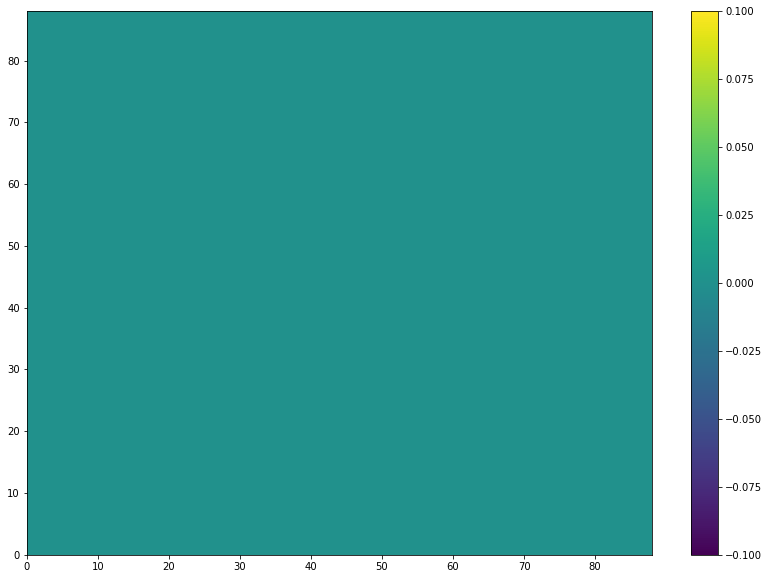

-----------------------------------------------------------------




In [30]:
# cycle over displacement (in angstrom) from water plane
for d in np.arange(2, 2.5, 0.5):
    print(f"Displacement: {d}A")
    P1 = np.array(oxygens[0]) # first water
    P2 = np.array(oxygens[1]) # second water
    P3 = P1-np.array([1,0,0]) # third (arbitrary) point on the plane
    N = np.cross(P2-P1, P3-P1) # normal to the plane
    N /= np.linalg.norm(N)
    center = d*N + (P1+P2)/2 # center of plane
    points = define_plane(P1+d*N, P2+d*N, P3+d*N, ppside, spacing)
    plane_vertices = np.array([points[0,0], points[0,ppside-1], points[ppside-1, ppside-1], points[ppside-1,0]])
    
    iso_surfaces = find_iso_surfaces(plane_vertices, center, g, iso_values)
    
    with open(f"save/iso/surfaces/somewhere/iso.p", "wb") as fisoout:
        pickle.dump(iso_surfaces, fisoout)
    
    values = find_density_value(points, iso_values, iso_surfaces)
    
    with open(f"save/density/values/somewhere/values.p", "wb") as fvalout:
        pickle.dump(values, fvalout)
    with open(f"save/planes/somewhere/points.p", "wb") as fplaneout:
        pickle.dump(points, fplaneout)
    print("-----------------------------------------------------------------")
    print()
    print()

In [32]:
X1 = np.arange(0, ppside, 1)
Y1 = np.arange(0, ppside, 1)
X, Y = np.meshgrid(X1, Y1)

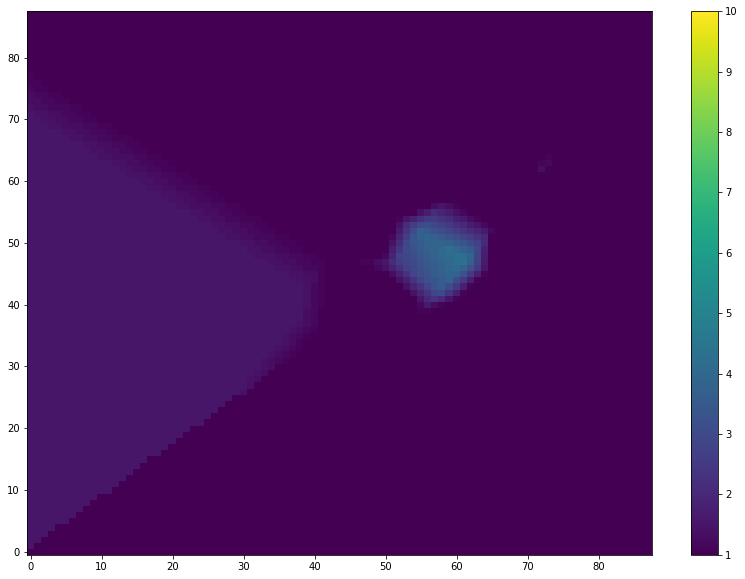

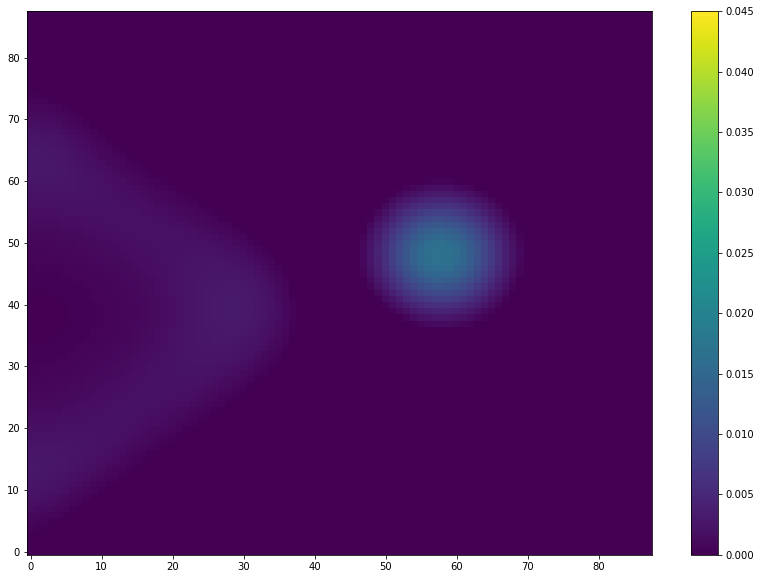

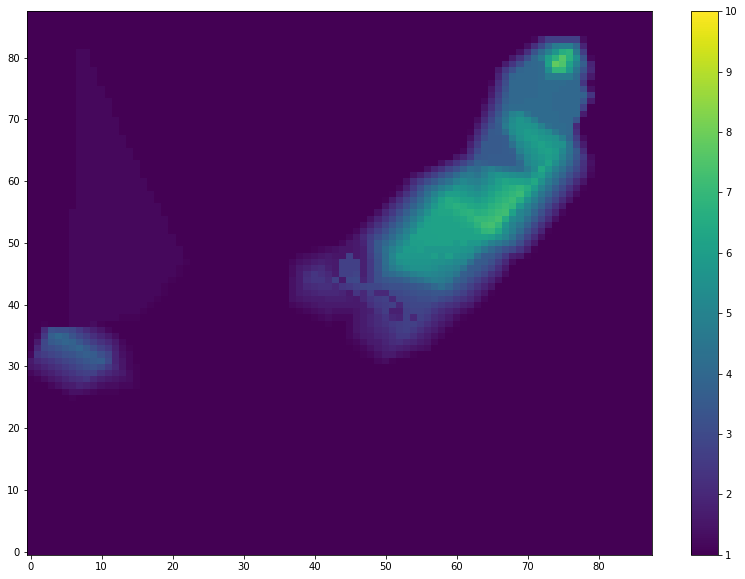

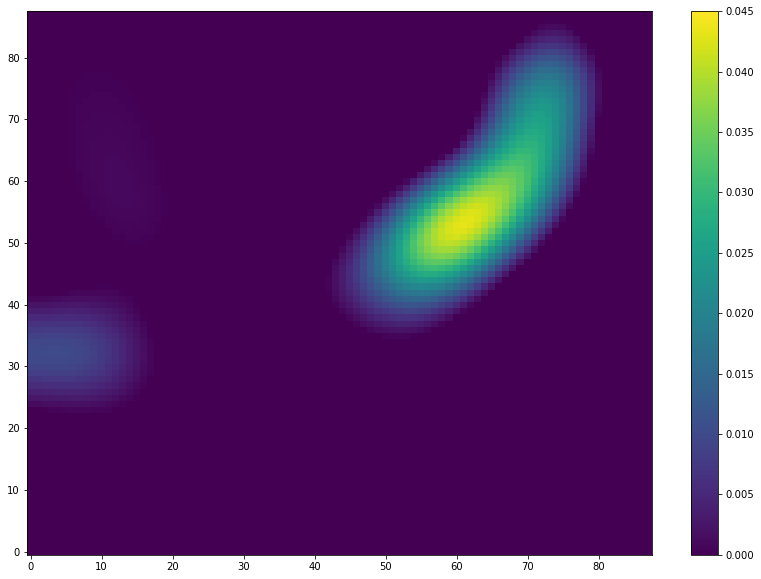

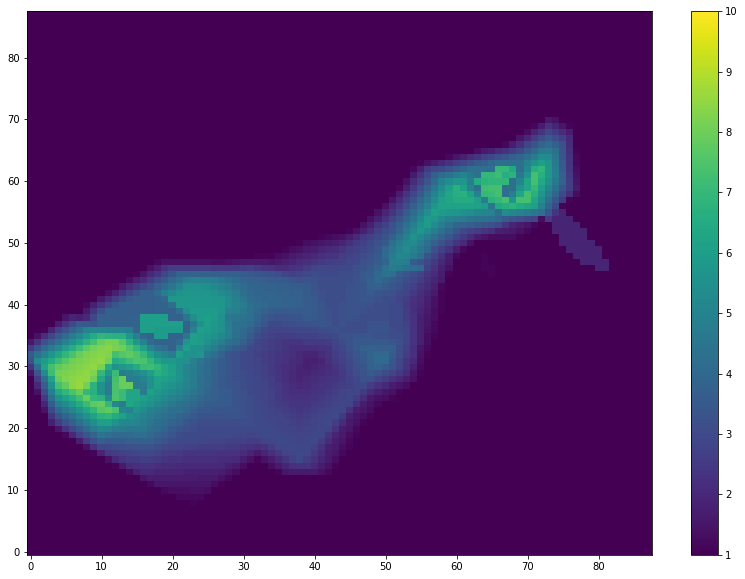

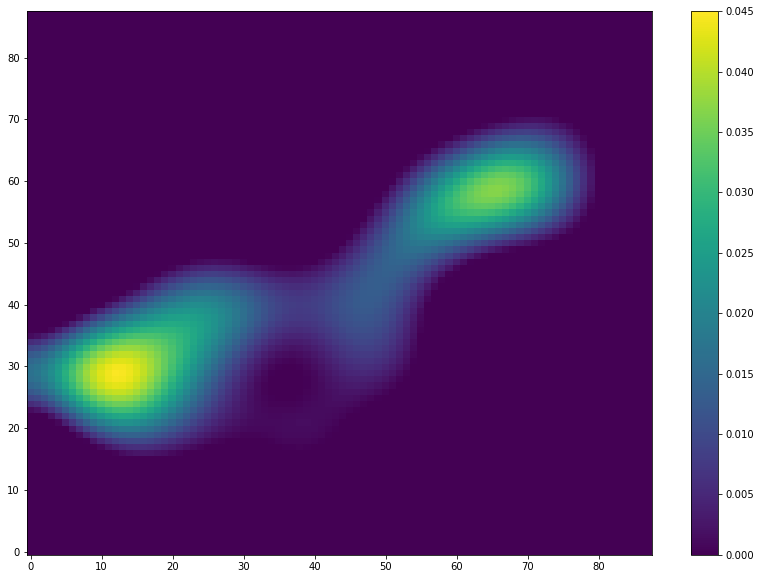

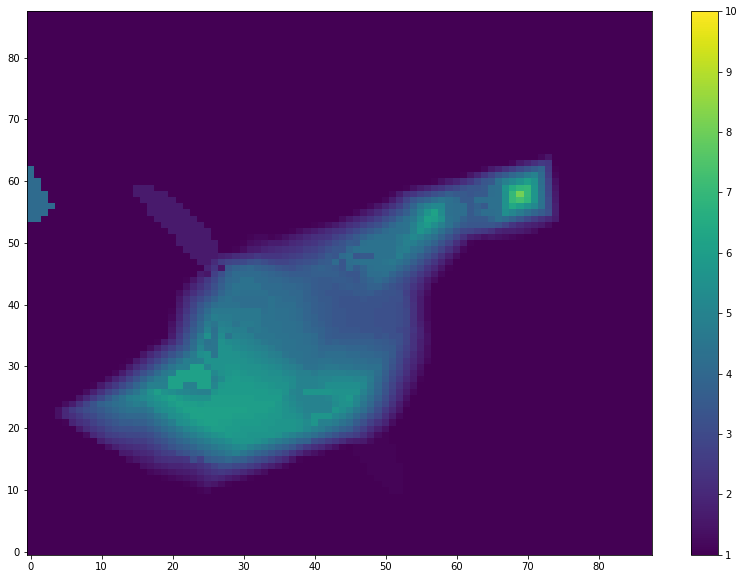

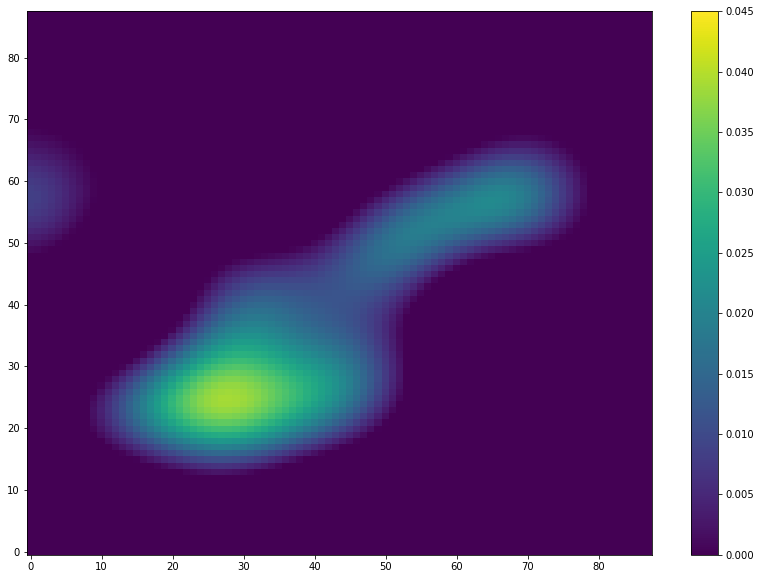

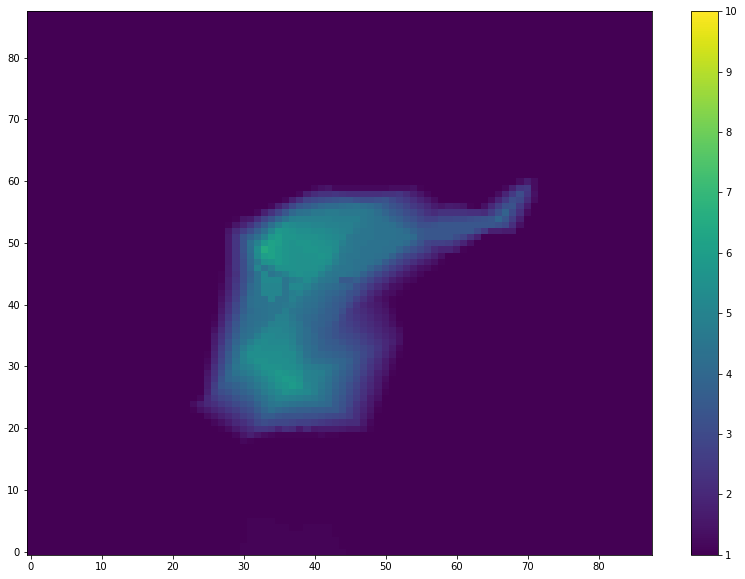

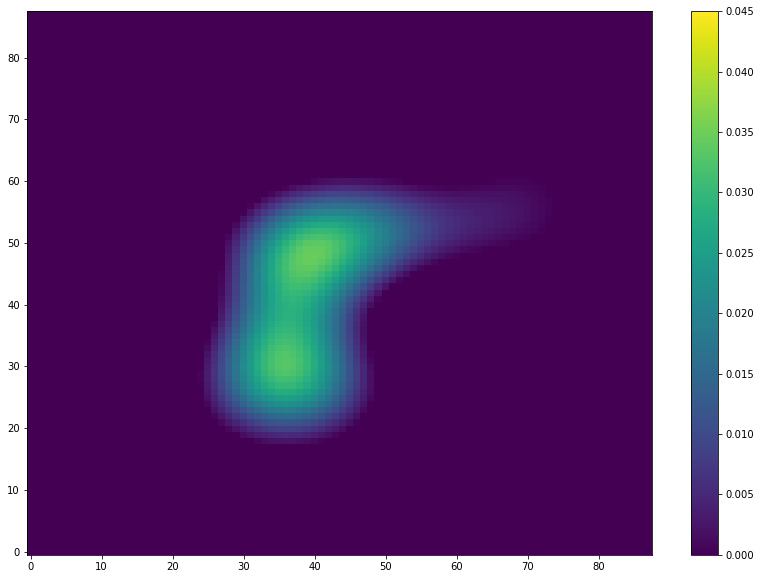

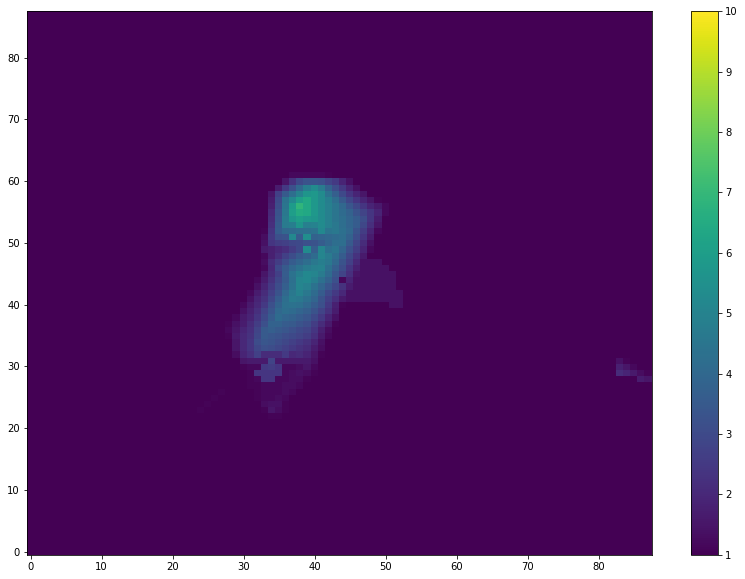

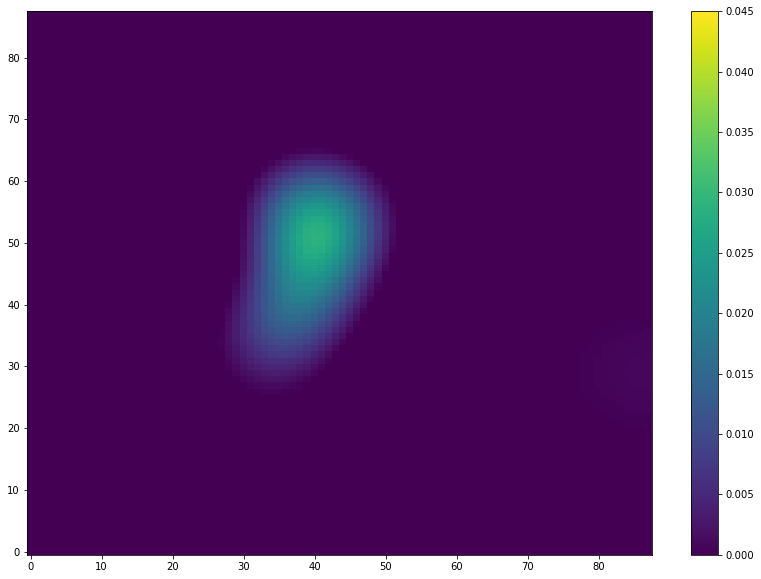

In [42]:
# perform smoothing with LoG (Laplacian of Gaussians) filter

sigma = 8

for d in np.arange(-1.0, 2.0, 0.5):
    values = pickle.load(open(f"path/to/density/slices/values.p", "rb"))
    
    fig, ax = plt.subplots(figsize=(14,10))
    c = ax.pcolormesh(X, Y, values, shading='auto', vmin=1, vmax=10)
    fig.colorbar(c, ax=ax)
    plt.show()
    
    log_result = -ndimage.gaussian_laplace(values, sigma=sigma)
    for i, row in enumerate(log_result):
        for j, val in enumerate(row):
            if val < 0:
                log_result[i,j] = 0
    
    fig, ax = plt.subplots(figsize=(14,10))
    c2 = ax.pcolormesh(X, Y, log_result, shading='auto', vmin=0, vmax=0.045)
    fig.colorbar(c2, ax=ax)
    plt.show()
    
    with open(f"save/smoothed/density/values/somewhere/smooth.p", "wb") as fvalout:
        pickle.dump(log_result, fvalout)